In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma.core import append
from scipy.stats import linregress

In [2]:
df = pd.read_excel("./data/Projet_I2M_2020-2021.xls")


# Initialize variables for cycle detection
cycle_number = 0
cycle_list = []
found_max = False  # Tracks if we've found the maximum
found_min = False  # Tracks if we've found the minimum

# Calculate the derivative of the strain and fill the first NaN value with 0
df['Strain_Derivative'] = df['Déformation'].diff().fillna(0)

# Iterate over the strain values and their derivatives
for i in range(1, len(df)):  # Start from index 1 to have a valid derivative
    strain_current = df['Déformation'].iloc[i]
    derivative_previous = df['Strain_Derivative'].iloc[i - 1]
    derivative_current = df['Strain_Derivative'].iloc[i]

    # Detect maxima (when derivative changes from positive to negative)
    if derivative_previous > 0 and derivative_current < 0:
        found_max = True

    # Detect minima (when derivative changes from negative to positive)
    if derivative_previous < 0 and derivative_current > 0 and found_max:
        found_min = True

    # Complete the cycle when both a maximum and minimum have been found
    if found_max and found_min and (df['Déformation'].iloc[i-1] * df['Déformation'].iloc[i]) < 0:
        cycle_number += 1
        found_max = False  # Reset for the next cycle
        found_min = False  # Reset for the next cycle

    # Append the current cycle number
    cycle_list.append(cycle_number)

# Ensure the first row also gets the initial cycle number
cycle_list = [0] + cycle_list

# Add the cycle list to the DataFrame
df['Cycle'] = cycle_list[:len(df)]  # Ensure the lengths match

df["stress_derivative"] = df["Contrainte (MPa)"].diff()

# Data analysing

Text(0.5, 1.0, 'Strain vs. Stress for the first cycle')

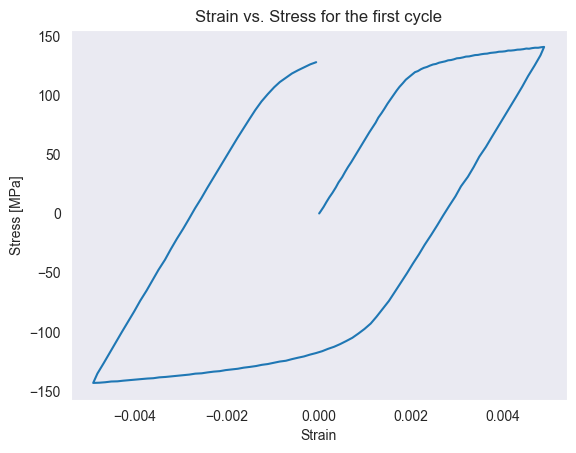

In [3]:
plt.plot(df[df["Cycle"]==0]["Déformation"], df[df["Cycle"]==0]["Contrainte (MPa)"])
plt.grid()
plt.xlabel("Strain")
plt.ylabel("Stress [MPa]")
plt.title("Strain vs. Stress for the first cycle")

In [4]:
def get_sigma_y(df, lim=2):
    deformation = df["Déformation"]
    stress = df["Contrainte (MPa)"]
    
    # Linear fit for the elastic region (assuming strain < 0.002 is elastic)
    elastic_region = df[deformation < 0.002]
    slope, intercept, _, _, _ = linregress(elastic_region["Déformation"], elastic_region["Contrainte (MPa)"])
    
    # Calculate the predicted stress based on the elastic fit
    predicted_stress = slope * deformation + intercept
    
    # Find the point where the curve deviates significantly (plastic region starts)
    deviation = np.abs(stress - predicted_stress)
    yield_index = deviation[deviation > lim].idxmin()  # Identify index of maximum deviation
    
    sigma_y = stress.loc[yield_index]  # Yield stress value
    strain_y = deformation.loc[yield_index]  # Strain at yield
    
    return sigma_y, strain_y, deformation, predicted_stress, slope

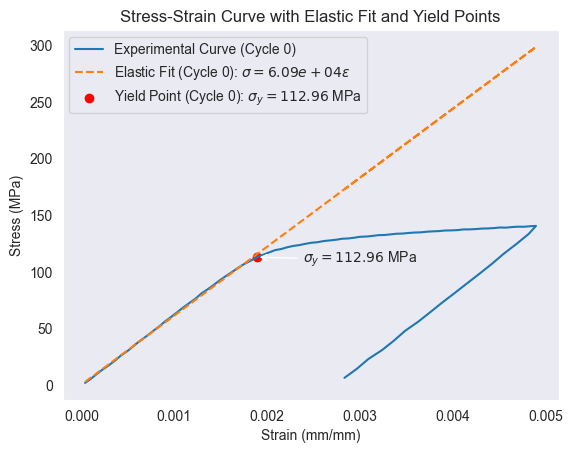

In [5]:
# First Yield Point and Elastic Fit (Cycle 0)
sigma_y, strain_y, deformation, predicted_stress, E = get_sigma_y(
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > 0)]
)

# Plot the experimental stress-strain curve for Cycle 0
plt.plot(
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > 0)]["Déformation"],
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > 0)]["Contrainte (MPa)"],
    label="Experimental Curve (Cycle 0)"
)

# Plot the elastic fit curve
plt.plot(
    deformation, predicted_stress, 
    label=rf'Elastic Fit (Cycle 0): $\sigma={E:.2e}\varepsilon$', linestyle='--'
)

# Highlight and annotate the first yield point (\sigma_y)
plt.scatter(strain_y, sigma_y, color='red', label=rf'Yield Point (Cycle 0): $\sigma_y={sigma_y:.2f}$ MPa')
plt.annotate(
    rf'$\sigma_y={sigma_y:.2f}$ MPa', 
    xy=(strain_y, sigma_y), 
    xytext=(strain_y + 0.0005, sigma_y - 5),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

sigma_y0 = sigma_y
strain_y0 = strain_y
# Add labels, title, legend, and grid
plt.xlabel("Strain (mm/mm)")
plt.ylabel("Stress (MPa)")
plt.title("Stress-Strain Curve with Elastic Fit and Yield Points")
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [6]:
def get_sigma_cycle(x, y, strain, stress, slope, lim):
    """
    Calculate the yield point (sigma_y and strain_y) based on the deviation 
    of the stress-strain curve from the elastic fit.
    
    Parameters:
        x (Series): Subset of strain values for fitting (independent variable).
        y (Series): Subset of stress values for fitting (dependent variable).
        strain (Series): Full strain values for deviation calculation.
        stress (Series): Full stress values for deviation calculation.
        slope (float): Elastic modulus (slope of the elastic line).
        lim (float): Threshold for significant deviation to identify the yield point.

    Returns:
        sigma_y (float): Yield stress value.
        strain_y (float): Strain value at the yield point.
        intercept (float): Calculated y-intercept of the elastic fit.
    """
    # Calculate the y-intercept (b) for the elastic fit
    intercept = np.mean(y) - slope * np.mean(x)

    # Calculate the deviation of the stress from the elastic fit
    deviation = np.abs(stress - (slope * strain + intercept))

    # Find the first point where the deviation exceeds the threshold
    yield_indices = deviation[deviation > lim].index
    if not yield_indices.empty:
        yield_index = yield_indices[0]  # Use the first index exceeding the threshold
    else:
        raise ValueError("No significant deviation found; adjust the 'lim' parameter.")

    sigma_y = stress.loc[yield_index]  # Yield stress
    strain_y = strain.loc[yield_index]  # Yield strain

    return sigma_y, strain_y, intercept

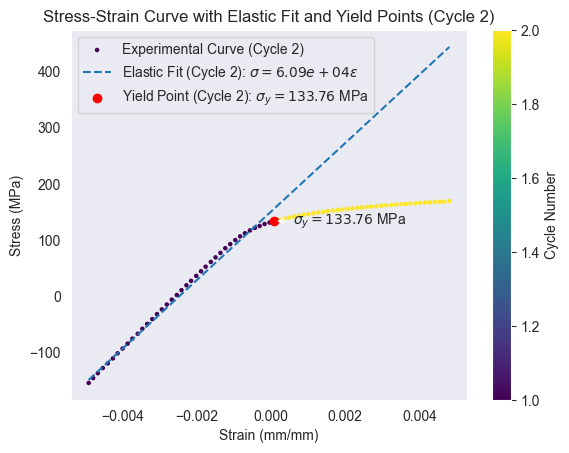

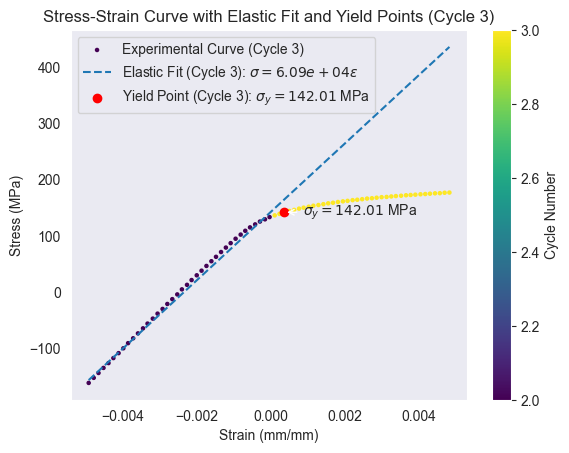

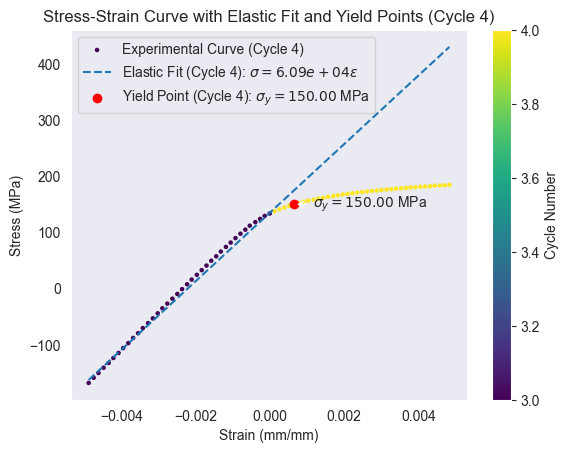

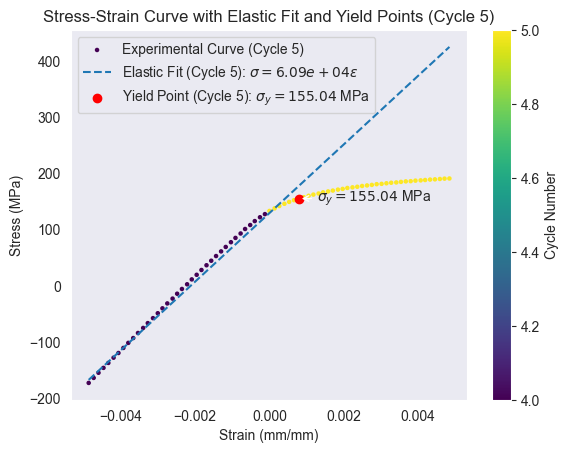

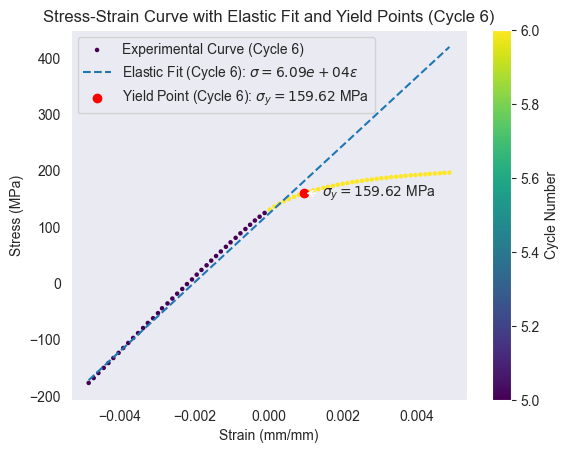

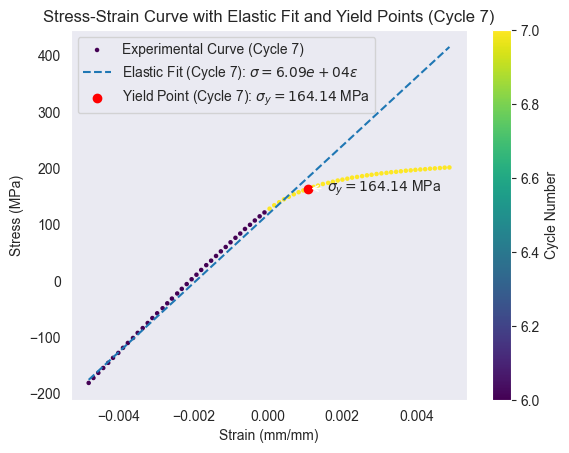

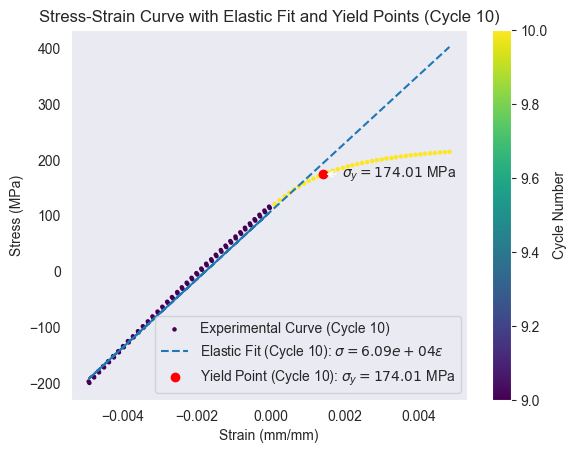

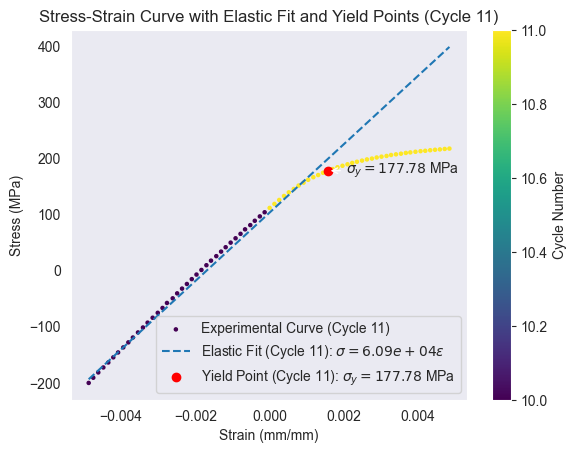

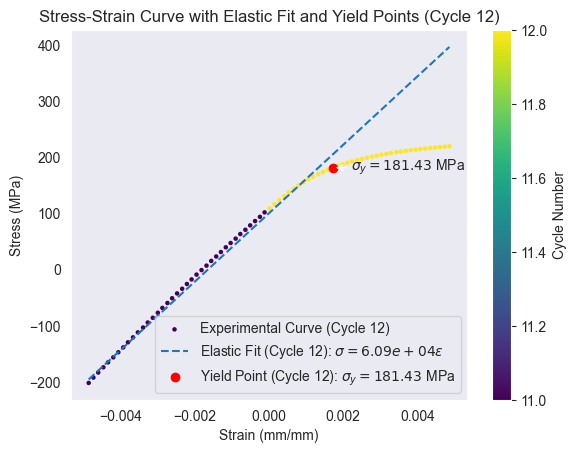

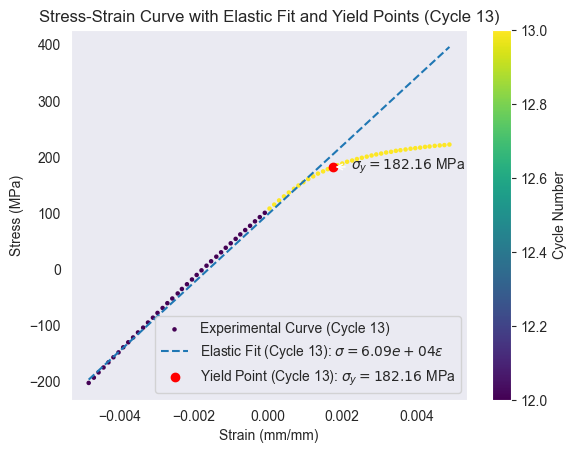

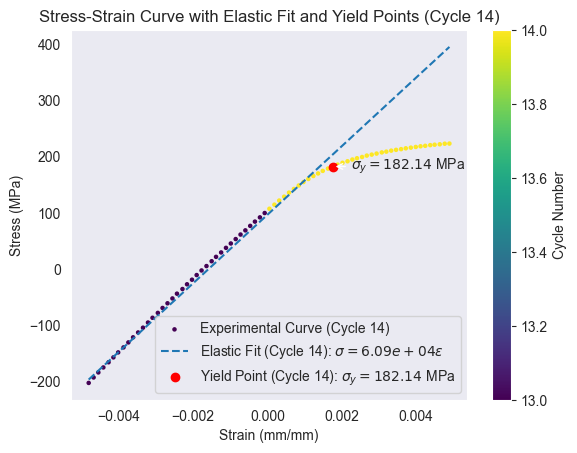

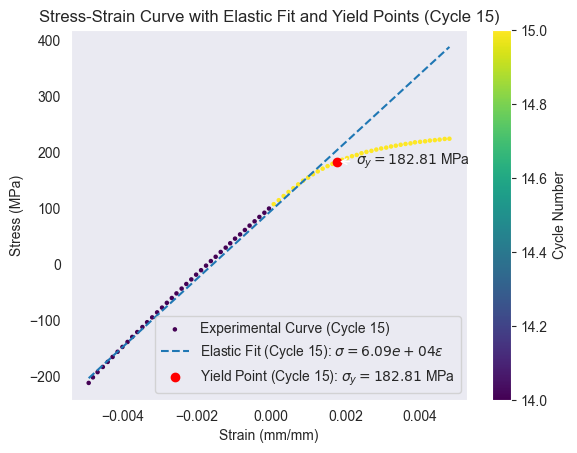

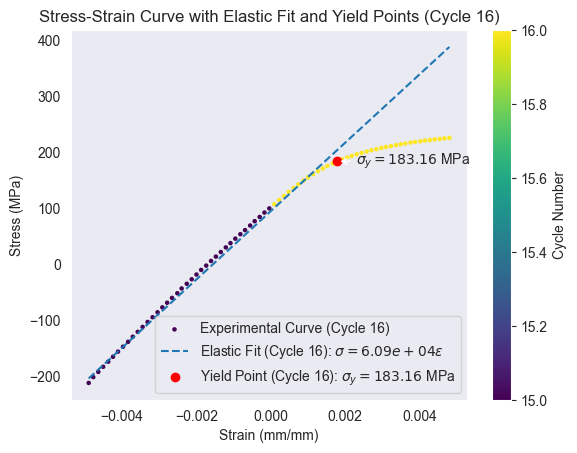

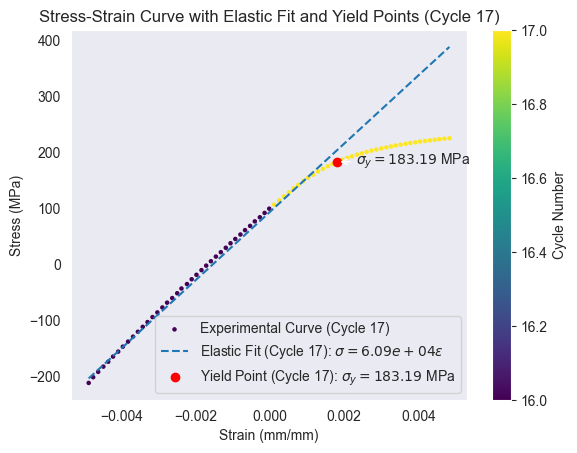

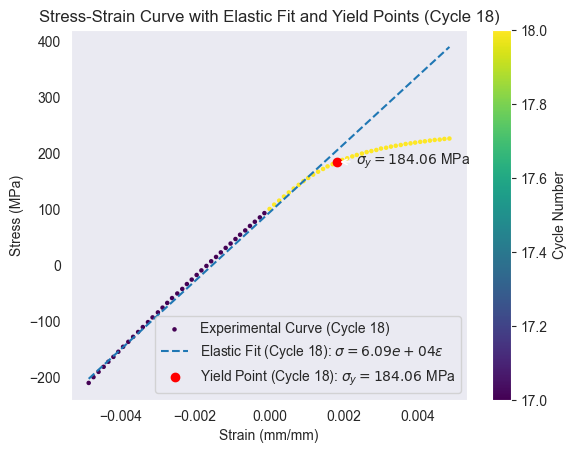

In [7]:
# List to store yield points
sigma_tab = [        {
            "Sigma_y" : sigma_y0,
            "Strain_y" : strain_y0,
            "Cycle" : 1
        }]

for i in [j for j in range(2,8)] + [j for j in range(10, cycle_number)]:
    plt.figure()

    # Filter the DataFrame for the current and previous cycle
    plotdf = df[
        ((df["Cycle"] == i - 1) & (df["stress_derivative"] > 0) & (df["Déformation"] < 0)) |
        ((df["Cycle"] == i) & (df["stress_derivative"] > 0) & (df["Déformation"] > 0))
    ]

    # Subset data for the elastic fit (example condition: strain < -0.003)
    subset = plotdf[plotdf["Déformation"] < -0.003]

    # Calculate Yield Point and Elastic Fit
    sigma_y, strain_y, intercept = get_sigma_cycle(
        subset["Déformation"],
        subset["Contrainte (MPa)"],
        plotdf["Déformation"],
        plotdf["Contrainte (MPa)"],
        E,
        20
    )

    # Plot the experimental stress-strain curve
    scatter = plt.scatter(
        plotdf["Déformation"],
        plotdf["Contrainte (MPa)"],
        label=f"Experimental Curve (Cycle {i})",
        s=5,
        c=plotdf["Cycle"],
        cmap="viridis"
    )

    # Add a color bar for cycle numbers
    plt.colorbar(scatter, label="Cycle Number")

    # Plot the elastic fit curve
    plt.plot(
        plotdf["Déformation"], E * plotdf["Déformation"] + intercept,
        label=rf'Elastic Fit (Cycle {i}): $\sigma={E:.2e}\varepsilon$',
        linestyle='--'
    )

    # Highlight and annotate the yield point
    plt.scatter(strain_y, sigma_y, color='red', label=rf'Yield Point (Cycle {i}): $\sigma_y={sigma_y:.2f}$ MPa')
    plt.annotate(
        rf'$\sigma_y={sigma_y:.2f}$ MPa',
        xy=(strain_y, sigma_y),
        xytext=(strain_y + 0.0005, sigma_y - 5),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=10
    )

    # Append the yield point data to sigma_tab
    sigma_tab.append(
        {
            "Sigma_y" : sigma_y,
            "Strain_y" : strain_y,
            "Cycle" : i
        }
    )

    # Add labels, legend, and grid
    plt.xlabel("Strain (mm/mm)")
    plt.ylabel("Stress (MPa)")
    plt.title(f"Stress-Strain Curve with Elastic Fit and Yield Points (Cycle {i})")
    plt.legend()
    plt.grid()

    # Save the plot as a PNG file
    plt.savefig(f"fig/{i}.png")


sigma_tab = pd.DataFrame(sigma_tab)

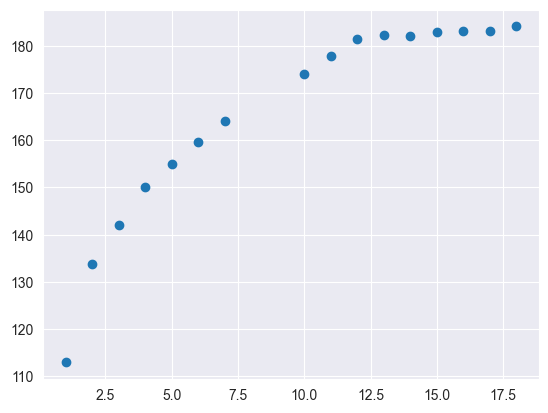

In [10]:
sigma_tab["R"] = sigma_tab["Sigma_y"] - sigma_tab["Sigma_y"][0]
plt.scatter(sigma_tab["Cycle"],sigma_tab["Sigma_y"])

In [11]:
sigma_tab

,Sigma_y,Strain_y,Cycle,R
0,112.955763,0.001891,1,0.000000
1,133.759575,0.000083,2,20.803812
2,142.012623,0.000365,3,29.056860
3,149.995689,0.000648,4,37.039926
4,155.043583,0.000796,5,42.087819
5,159.621180,0.000940,6,46.665416
6,164.138330,0.001093,7,51.182567
7,174.013559,0.001424,10,61.057796
8,177.777464,0.001570,11,64.821701
9,181.428072,0.001725,12,68.472308


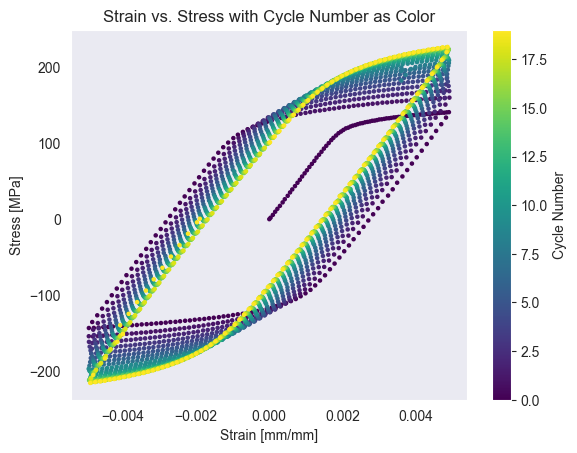

In [12]:
# Scatter plot with the cycle number as the hue (color)
scatter = plt.scatter(df["Déformation"], df["Contrainte (MPa)"], c=df['Cycle'], cmap='viridis', s=5)

# Add color bar to the plot
plt.colorbar(scatter, label='Cycle Number')

# Label the axes
plt.xlabel("Strain [mm/mm]")
plt.ylabel("Stress [MPa]")

# Set title
plt.title('Strain vs. Stress with Cycle Number as Color')
plt.grid()

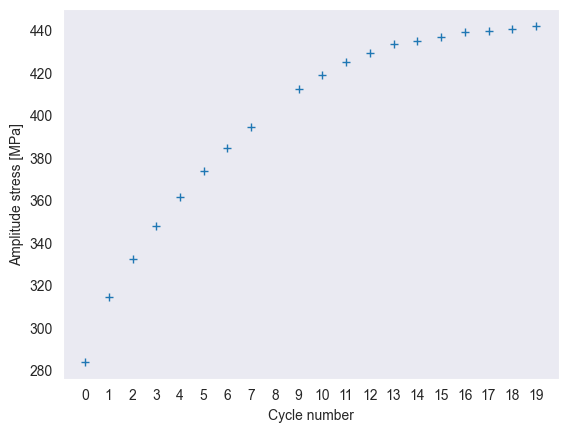

In [15]:
data2plot = []
for cycle in np.unique(df["Cycle"]):
    if cycle != 8:
        data2plot.append([
            cycle, 
            df[df["Cycle"]==cycle]["Contrainte (MPa)"].max() - df[df["Cycle"]==cycle]["Contrainte (MPa)"].min()
        ])
data2plot = np.array(data2plot)

plt.plot(data2plot[:,0], data2plot[:,1], "+")
plt.xlabel("Cycle number")
plt.ylabel("Amplitude stress [MPa]")
plt.grid()
plt.xticks([i for i in range(20)]);
